In [1]:
# !pip install matplotlib==3.6.1 imageio
# !mkdir animation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import Image
import imageio
import copy

## Rigid body transformation

In this hands-on session, we will review the rigid body transformation and introduce some numerical examples. 



### Rotation matrix

$R \in \mathrm{SO}(3) = \{R\in \mathbb{R}^{3 \times 3} \mid R^{\intercal}R = I_3, \det(R) = 1\}. $

Consider the column space of the rotational matrix:

$R:= [r_1, r_2, r_3]\in \mathbb{R}^{3\times 3}, r_1,r_2,r_3\in \mathbb{R}^3,$

we have the following property:

(a) Orthonormality: 

$\|r_1\|^2=\|r_2\|^2=\|r_3\|^2 = 1 $, 

$ r_1^{\intercal}r_2 = r_2^{\intercal}r_3 = r_1^{\intercal}r_3 = 0.$

(b) Right hand rule (equivalent to $\det(R) = 1$):

$ r_1\times r_2 - r_3 = r_2\times r_3 - r_1 = r_3\times r_1 - r_2 = 0_{3\times 1}.$

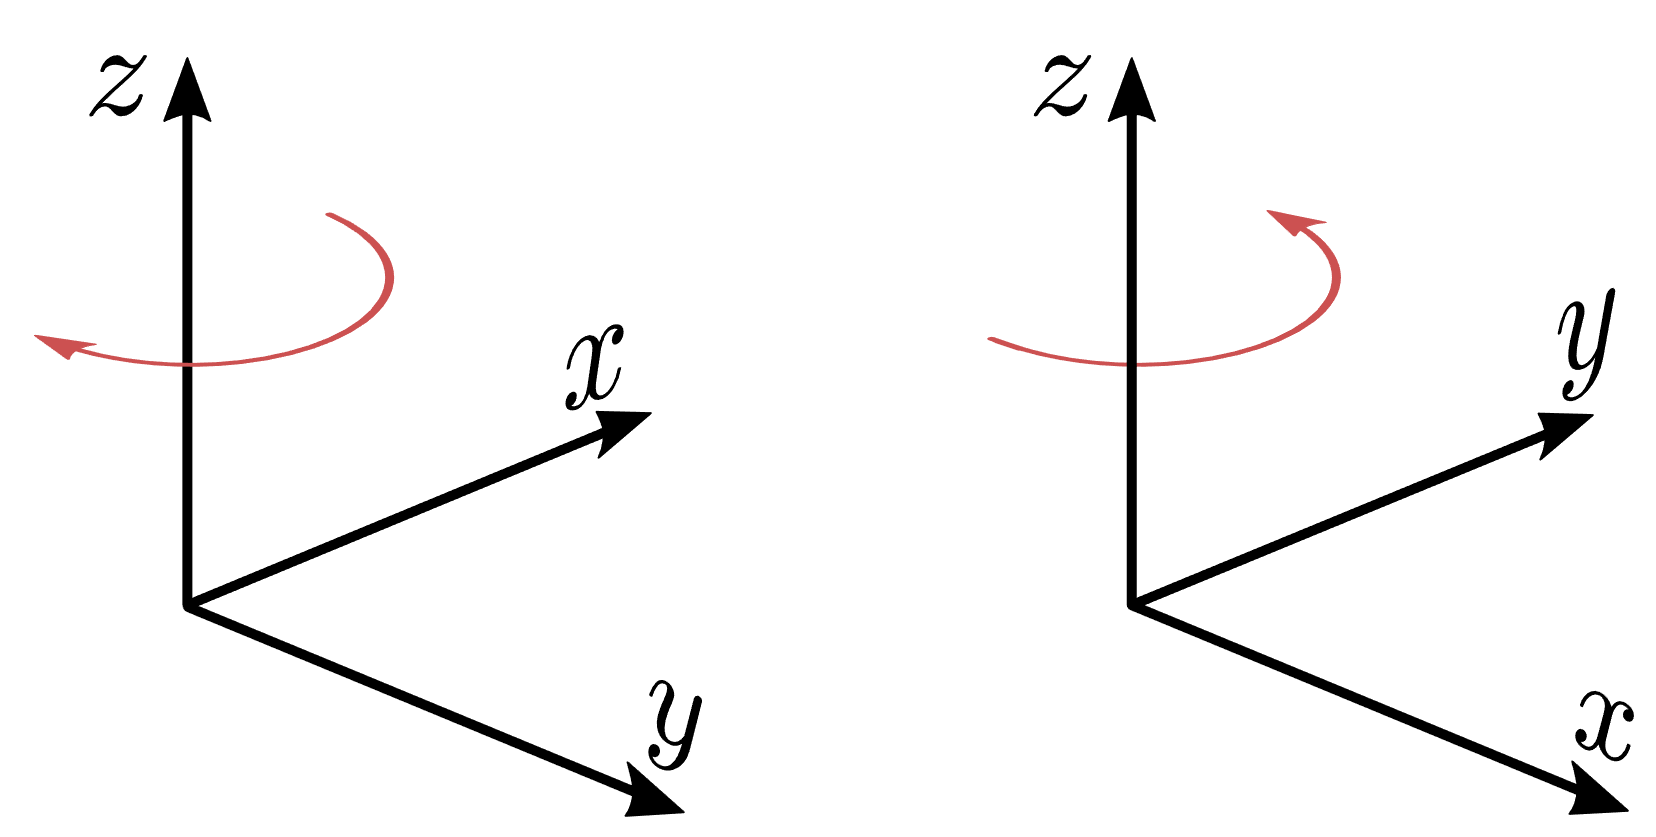

left: left-hand rule, right: right-hand rule

ref: https://en.wikipedia.org/wiki/Right-hand_rule#/media/File:Cartesian_coordinate_system_handedness.svg

Q: Why following right-hand rule is equivalent to $\det(R) = 1$ for $R\in SO(3)$?

Hint: What is the geometric meaning of determinant? 

https://en.wikipedia.org/wiki/Determinant


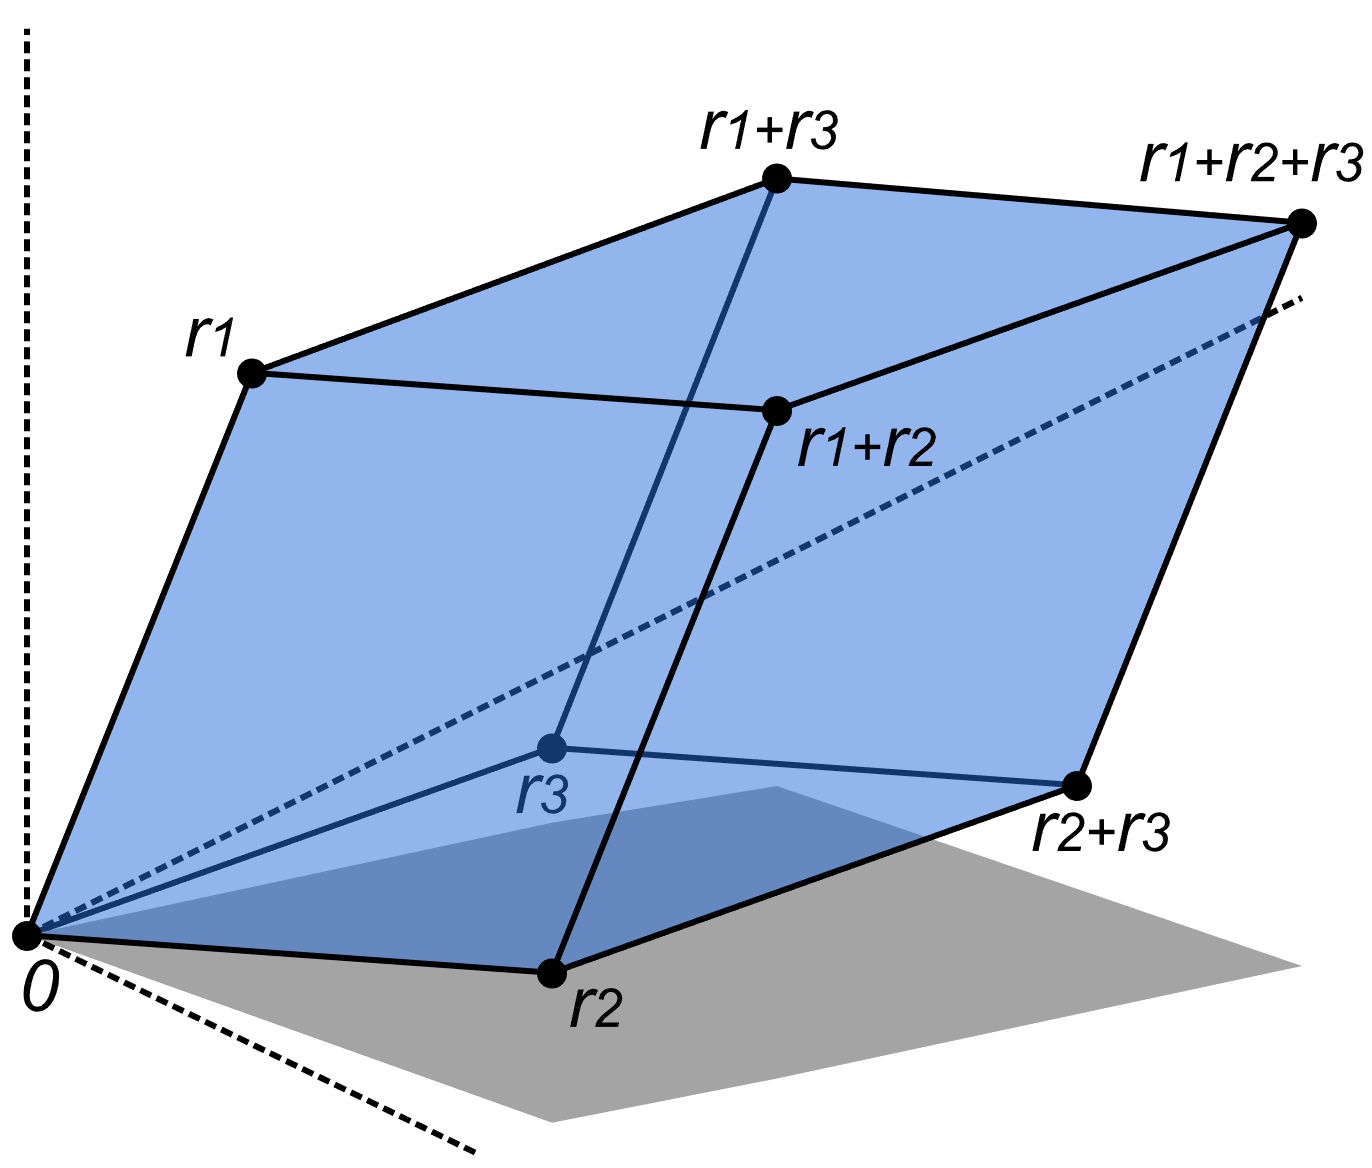



The right-hand rule ensures that $R$ will not "flip" the directions when rotate a vector. 

In [3]:
def vee(A):
    # so(3) -> R^3
    return np.array([[A[2, 1]], [A[0, 2]], [A[1, 0]]])


def wedge(v):
    # R^3 -> so(3)
    vx = np.zeros((3,3))
    
    vx[0, 1] = - v[2]
    vx[0, 2] =   v[1]
    vx[1, 0] =   v[2]
    vx[2, 0] = - v[1]
    vx[1, 2] = - v[0]
    vx[2, 1] =   v[0]
    
    return vx

def Rodrigues(v):
    ### Rodrigues rotation formula
    ### Closed form of exponential series for SO(3)
    theta = np.linalg.norm(v, 2)
    if theta < 1e-6:
        v = v
        theta = 0.0
    else:
        v = v / theta
    
    vx = wedge(v)
    
    R = np.identity(3) + np.sin(theta) * vx + (1 - np.cos(theta))* np.matmul(vx, vx)
    return R

v = np.random.randn(3, 1)
R = Rodrigues(v)

print("Check the orthonormality: ")
print(R @ R.T)

print("\n")
print("Check the right-hand rule: ")
print(np.cross(R[:, 0], R[:, 1]) - R[:, 2])
print(np.cross(R[:, 1], R[:, 2]) - R[:, 0])
print(np.cross(R[:, 2], R[:, 0]) - R[:, 1])

print("\n")
print("Check the determinant: ")
print(np.linalg.det(R))

Check the orthonormality: 
[[ 1.00000000e+00  2.77555756e-17  1.11022302e-16]
 [ 2.77555756e-17  1.00000000e+00 -8.67361738e-17]
 [ 1.11022302e-16 -8.67361738e-17  1.00000000e+00]]


Check the right-hand rule: 
[-1.11022302e-16  1.38777878e-17 -1.11022302e-16]
[ 0.00000000e+00  0.00000000e+00 -5.55111512e-17]
[ 1.11022302e-16 -1.11022302e-16  0.00000000e+00]


Check the determinant: 
0.9999999999999999


###  $(\cdot)^\vee$ map and $(\cdot)^\wedge$ map for SO(3)

How to generate a rotational matrix from angular velocity? 

Let $v = \begin{bmatrix} x \\ y\\ z\end{bmatrix}$.

The wedge map:

${(\cdot)}^{\wedge}: \mathbb{R}^3 \rightarrow so(3)$ is defined as:

$v^{\wedge}=\begin{bmatrix}0 & -z & y\\z & 0 & -x\\-y & x & 0 \end{bmatrix}$, $v^{\wedge} u = v \times u$. 

The inverse of ${(\cdot)}^{\wedge}$, vee map is defined as

${(\cdot)}^{\vee}: so(3) \rightarrow \mathbb{R}^3$: 

$(v^{\wedge})^{\vee}=\left( \begin{bmatrix}0 & -z & y\\z & 0 & -x\\-y & x & 0 \end{bmatrix} \right)^{\vee} = v$

Consider the canonical basis for $R^3$, i.e. $e_1, e_2, e_3$, let $G_i = e_i^{\wedge}$. 

Some computation property:

$\forall a, b \in \mathbb{R}^3$

(a): $a^{\wedge}b = a \times b$ (cross product)

(b): $[a^{\wedge}, b^{\wedge}]:=a^{\wedge}b^{\wedge} - b^{\wedge}a^{\wedge} = (a \times b)^{\wedge} $ (Lie bracket)

(c): $a \times b = \sum_i  a_i G_i b$ (Cross product expressed in canonical basis)

(d): $[G_i, G_j] = (e_i \times e_j)^{\wedge} $ (Lie bracket expressed in canonical basis)


The cross product defines a Lie bracket on $\mathbb{R}^3$. The meaning of Lie bracket will be introduced in the next few lectures:

$(Rb)^{\wedge} = R b^{\wedge} R^{-1}$ (Rotate $b$ to another pose)

The infinitesimal case: 

$R=\exp{(a^{\wedge}\delta t)}$, 

$\lim_{\delta t \rightarrow 0} \frac{R b^{\wedge} R^{-1}}{\delta t}
= \lim_{\delta t \rightarrow 0} \frac{(I+a^{\wedge}\delta t + h.o.t)b^{\wedge}(I-a^{\wedge}\delta t + h.o.t)}{\delta t}
= a^{\wedge}b^{\wedge} - b^{\wedge}a^{\wedge}$

In [4]:
a = np.random.randn(3)
b = np.random.randn(3)

e1 = np.array([1.0, 0, 0])
e2 = np.array([0, 1.0, 0])
e3 = np.array([0, 0, 1.0])

G1 = wedge(e1)
G2 = wedge(e2)
G3 = wedge(e3)


print("Cross product: ")
print(np.cross(a, b) - wedge(a) @ b)
print("\n")

print("Lie bracket: ")
print((wedge(a) @ wedge(b) - wedge(b) @ wedge(a)) - wedge(np.cross(a, b)) )
print("\n")

print("Cross product expressed in canonical basis: ")
print(np.cross(a, b) - (a[0] * G1 @ b + a[1] * G2 @ b + a[2] * G3 @ b))
print("\n")

print("Lie bracket expressed in canonical basis: ")
print((G1 @ G2 - G2 @ G1) - wedge(np.cross(e1, e2)))
print((G2 @ G3 - G3 @ G2) - wedge(np.cross(e2, e3)))
print((G3 @ G1 - G1 @ G3) - wedge(np.cross(e3, e1)))

Cross product: 
[0. 0. 0.]


Lie bracket: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Cross product expressed in canonical basis: 
[0. 0. 0.]


Lie bracket expressed in canonical basis: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### The reconstruction equation for SO(3): 

How to generate the rotation matrix from angular velocity?

We have the reconstruction equation as the equation of motion: 

$\dot{R} = R \omega^{\wedge}, R \in SO(3), \omega^{\wedge} \in so(3). $

Note that $\dot{R}$ is in the tangent space at $R$, $ \dot{R} \in T_RSO(3) $.

An intuition is that we map the angular velocity in the body frame $\omega$ to the global frame by linear transformation $R$.

By integrating the angular velocity, we could obtain the rotation matrix. 

The integration of constant velocity in $SO(3)$ has closed form, called Rodrigues' rotation formula:

Let $\theta=\omega \Delta t$

$\exp{(\theta^{\wedge})}=\sum_{k=0}^{\infty} \frac{\theta^{\wedge k}}{k!} = I+\frac{\sin(\|\theta\|)}{\|\theta\|}\theta^{\wedge} + \frac{1 - \cos(\|\theta\|)}{\|\theta\|^2}\theta^{\wedge2}$

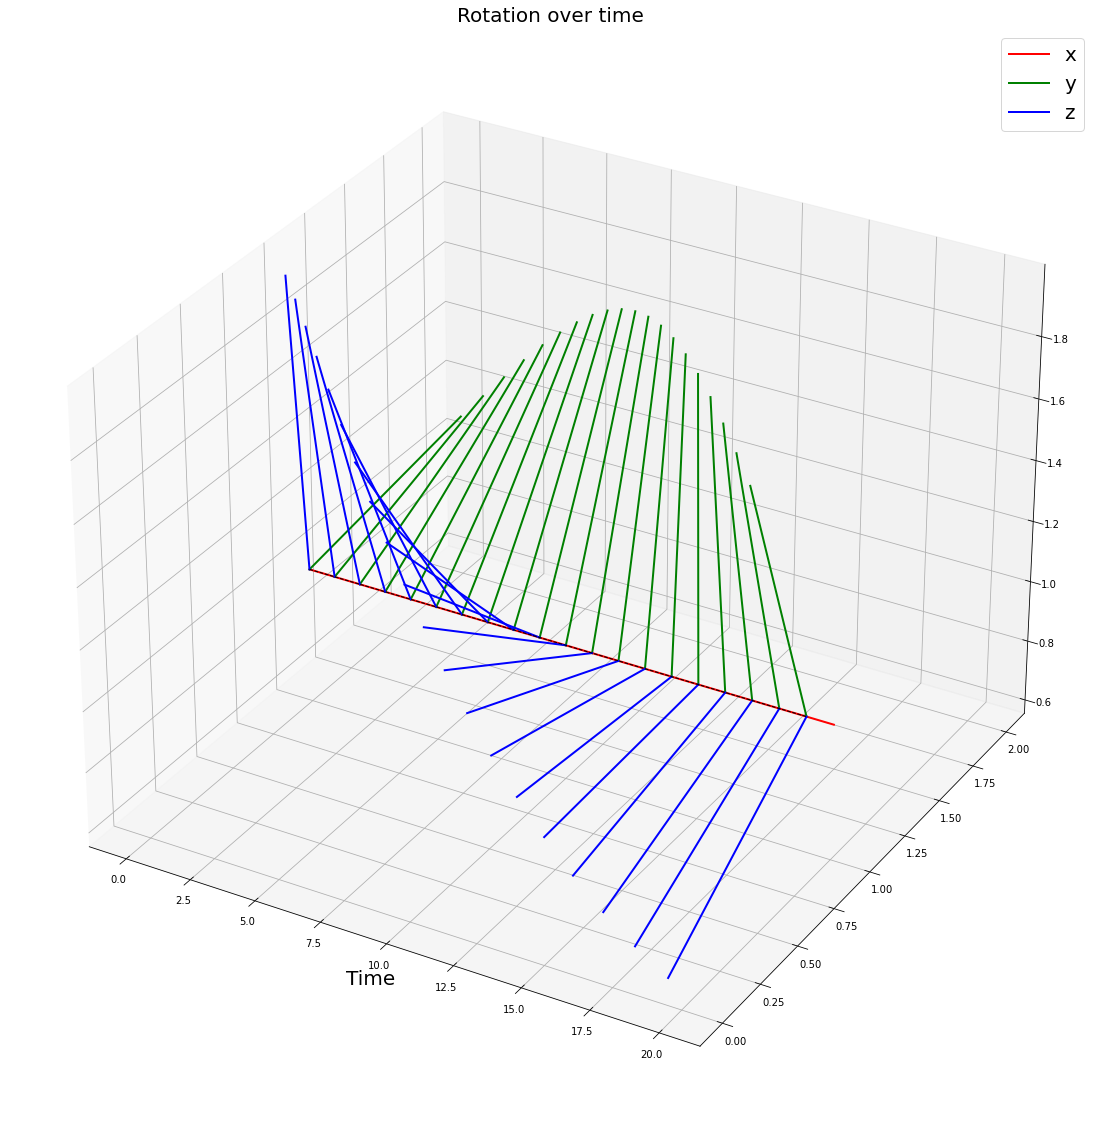

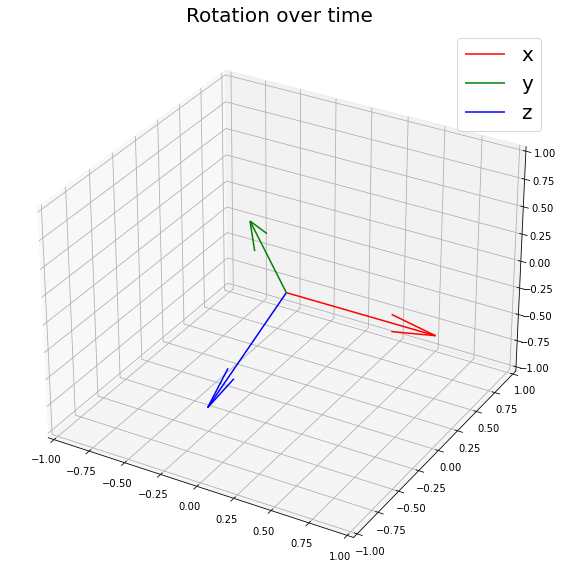

In [5]:
def update_SO3(R1, w1, dt):
    dR = Rodrigues(w1 *  dt)
    R2 = R1 @ dR
    return R2

w = np.zeros((3, 1))

R = np.eye(3)

step = 20
dt = 0.1
len = 1

x = np.array([1, 0, 0])
y = np.array([0, 1, 0])
z = np.array([0, 0, 1])

# initializa the x axis matrix
X = np.zeros((3, step))
Y = np.zeros((3, step))
Z = np.zeros((3, step))

pos = np.zeros((3, step))
pos[0, :] = np.arange(0, step, 1)
pos[1, :] = 1
pos[2, :] = 1

# Plot the axes and coordinate system at each time step
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for k in range(step):

    ### modify your twist profile here ###
    w[0] = 1.0 # np.sin(k * dt * np.pi)
    w[1] = 0.0 # np.cos(k * dt)
    w[2] = 0.0 # np.sin(k * dt * np.sqrt(2))
    ### modify your twist profile here ###

    R = update_SO3(R, w, dt)

    X[:, k] = np.dot(R, x)
    Y[:, k] = np.dot(R, y)
    Z[:, k] = np.dot(R, z)

    
    # if (k % 2 == 0) or (k < 10):
    dx = R[:, 0] * len
    dy = R[:, 1] * len
    dz = R[:, 2] * len

    ax.plot([pos[0, k], pos[0, k] + dx[0]], [pos[1, k], pos[1, k] + dx[1]], [pos[2, k], pos[2, k] + dx[2]], 'r-', linewidth=2)
    ax.plot([pos[0, k], pos[0, k] + dy[0]], [pos[1, k], pos[1, k] + dy[1]], [pos[2, k], pos[2, k] + dy[2]], 'g-', linewidth=2)
    ax.plot([pos[0, k], pos[0, k] + dz[0]], [pos[1, k], pos[1, k] + dz[1]], [pos[2, k], pos[2, k] + dz[2]], 'b-', linewidth=2)


ax.plot(pos[0, :], pos[1, :], pos[2, :], 'k--', linewidth=1)
# ax.set_aspect('equal', adjustable='box')


# add labels and title
ax.set_xlabel('Time', fontsize=20)
ax.set_title('Rotation over time',fontsize=20)
ax.legend(['x', 'y', 'z'],fontsize=20)
plt.show()

# save the figure
fig.savefig('rotation.png', bbox_inches='tight')

# Plot the 4D graph
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')


def update(frame):
    ax.clear()
    ax.quiver(0, 0, 0, X[0, frame], X[1, frame], X[2, frame], color='r')
    ax.quiver(0, 0, 0, Y[0, frame], Y[1, frame], Y[2, frame], color='g')
    ax.quiver(0, 0, 0, Z[0, frame], Z[1, frame], Z[2, frame], color='b')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.legend(['x', 'y', 'z'],fontsize=20)
    ax.set_title('Rotation over time',fontsize=20)

ani = FuncAnimation(fig, update, frames=step, repeat=True, interval=100)
# Save the animation as a GIF
ani.save('rotation_only.gif', writer='imagemagick', fps=10)
# do not show the animation
plt.show()



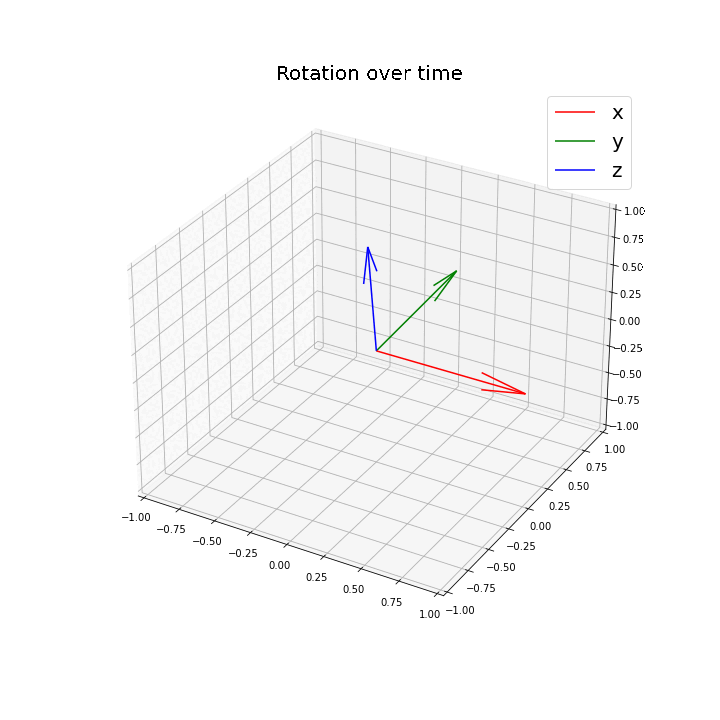

In [6]:
# play the gif
with open('rotation_only.gif','rb') as file:
    display(Image(file.read(), format='png', width=500, height=500))


### Rigid body motion on SE(3)

The homogeneous representation for rigid pose is defined as:

$X:= \begin{bmatrix} R, p \\ 0, 1\end{bmatrix} \in SE(3), R \in SO(3), p \in \mathbb{R}^3$

where $R$ is the orientation and $p$ is the position in the body frame. With this representation we can apply 2 transforms by directly multiplying two SE(3) matrices.

Similarly, we could define the $(\cdot)^\vee$ map and $(\cdot)^\wedge$ map for $SE(3)$. 

Suppose the twist $\xi := \begin{bmatrix} \omega \\ v \end{bmatrix} \in \mathbb{R}^6$, then we have:

$\xi^{\wedge}=\begin{bmatrix} \omega^\wedge & v \\ 0_{1\times 3} & 0 \end{bmatrix}\in{se}(3) .$

The reconstruction equation of $SE(3)$ could be written as:

$\dot{X}=X\xi^{\wedge} = \begin{bmatrix} R\omega^{\wedge} & Rv \\ 0_{1\times 3} & 0\\ \end{bmatrix}$

Similarly, we can integrate the reconstruction equation in $SE(3)$:

$\exp{(\xi^{\wedge}\Delta t)}:=\exp{\left(\begin{bmatrix}\omega^{\wedge} & v\\0_{1\times 3} & 0 \end{bmatrix}\Delta t\right)}=\sum_{k=0}^{\infty}\frac{(\xi^{\wedge k})\Delta t^k}{k!}=\begin{bmatrix}\exp{(\omega^{\wedge}\Delta t)} & J_l(\omega^{\wedge}\Delta t)v\Delta t\\0_{1\times 3} & 1 \end{bmatrix}$

The series have closed form solutions: 

$\begin{bmatrix}\omega^{\wedge} & v\\0_{1\times 3} & 0 \end{bmatrix}^2= \begin{bmatrix}\omega^{\wedge} & v\\0_{1\times 3} & 0 \end{bmatrix} \begin{bmatrix}\omega^{\wedge} & v\\0_{1\times 3} & 0 \end{bmatrix} = \begin{bmatrix}\omega^{\wedge 2} & \omega^{\wedge}v\\0_{1\times 3} & 0 \end{bmatrix}$

$\begin{bmatrix}\omega^{\wedge} & v\\0_{1\times 3} & 0 \end{bmatrix}^{k}= \begin{bmatrix}\omega^{\wedge k} & \omega^{\wedge k-1}v\\0_{1\times 3} & 0 \end{bmatrix}$

In case you want to know how to get the seiries:

${\Gamma}_m({\theta}) \triangleq\left(\sum_{n=0}^{\infty} \frac{1}{(n+m) !}({\theta})^{\wedge n}\right)$

If m = 0, we have the Rodrigues' rotation formula:

${\Gamma}_0({\theta})={I}_3+\frac{\sin (\|{\theta}\|)}{\|{\theta}\|}{\theta}^{\wedge}+\frac{1-\cos (\|{\theta}\|)}{\|{\theta}\|^2}{\theta}^{\wedge2}$

If m = 1, we have the left Jacobian $J_l(\theta^{\wedge})$:

${\Gamma}_1({\theta})={I}_3+\frac{1-\cos (\|{\theta}\|)}{\|{\theta}\|^2}{\theta}^{\wedge}+\frac{\|{\theta}\|-\sin (\|{\theta}\|)}{\|{\theta}\|^3}{\theta}^{\wedge2}$

Ref: 

Appendix A of https://journals.sagepub.com/doi/pdf/10.1177/0278364919894385 

Cayley–Hamilton theorem: https://en.wikipedia.org/wiki/Cayley%E2%80%93Hamilton_theorem 

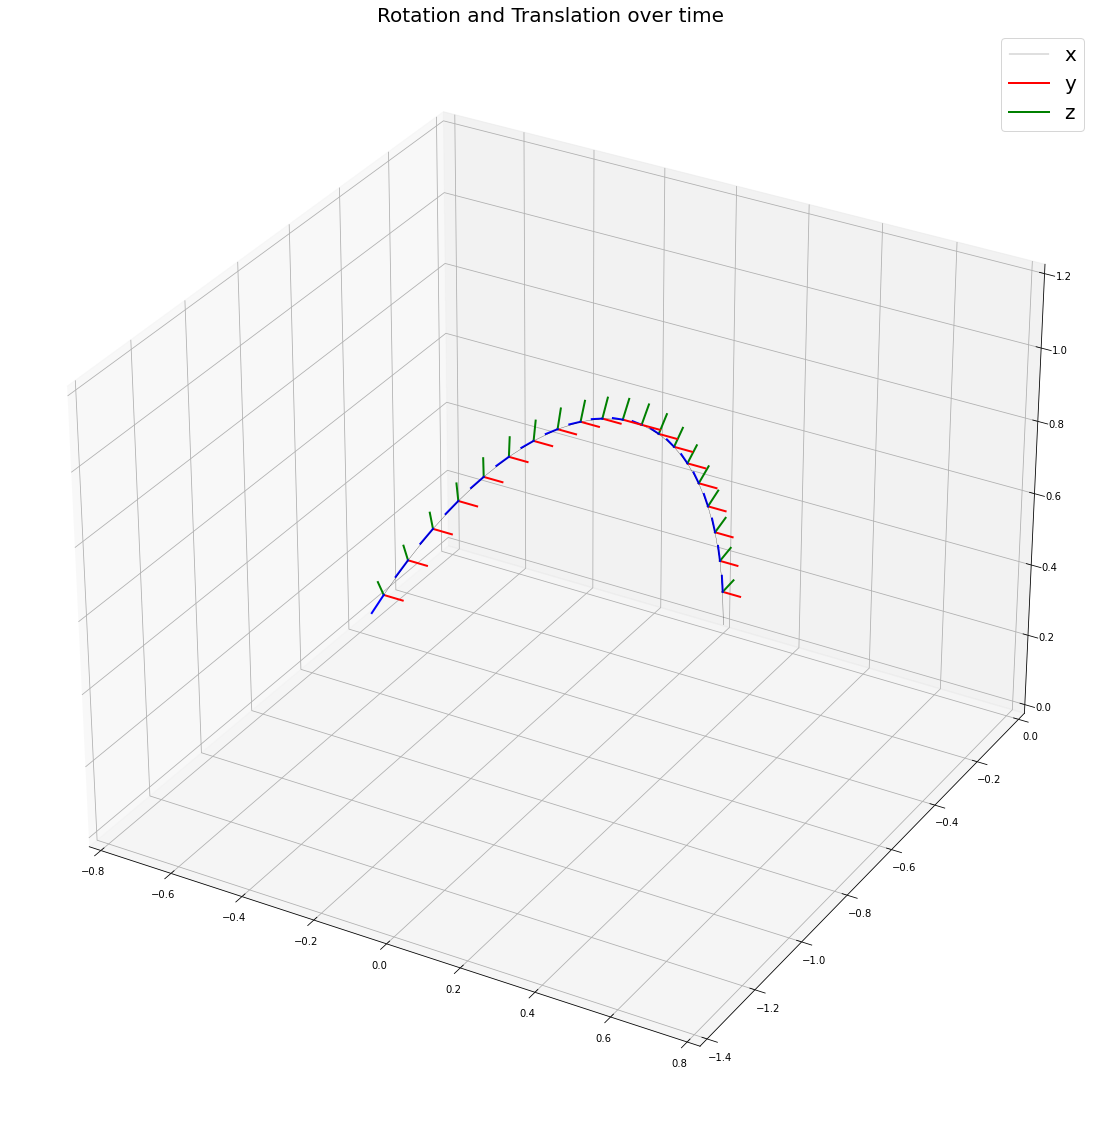

In [7]:
def Jleft_SO3(v):
    theta = np.linalg.norm(v, 2)
    vx = wedge(v)
    J = np.identity(3) + (1 - np.cos(theta)) / (theta**2) * vx + (theta - np.sin(theta)) / (theta**3) * np.matmul(vx, vx)
    return J


def update_SE3(X1, xi, dt):
    
    w = xi[0:3]
    v = xi[3:]
    
    
    dR = Rodrigues(w *  dt)
    dp = X1[0:3, 0:3] @ Jleft_SO3(w * dt) @ v.reshape(3, 1) * dt
    
    X2 = np.eye(4)
    
    X2[0:3, 0:3] = X1[0:3, 0:3] @ dR
    X2[0:3, 3] = X1[0:3, 3] + dp.reshape((3))
    # print(X1[0:3, 3])
    return X2

xi = np.zeros((6, 1))


X = np.eye(4)
X_prev = X

step = 20
dt = 0.1
len = 0.05

# Plot the axes and coordinate system at each time step
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for k in range(step):

    ### modify your twist profile here ###
    xi[0] = 1.0 # np.sin(k * dt * np.pi)
    xi[1] = 0.0 # np.cos(k * dt)
    xi[2] = 0.0 # np.sin(k * dt * np.sqrt(2))
    
    xi[3] = 0.0 # np.sin(k * dt * np.sqrt(np.pi))
    xi[4] = 0.0 # np.cos(k * dt / 2)
    xi[5] = 1.0 # np.sin(k * dt * np.sqrt(3))
    ### modify your twist profile here ###

    
    X = update_SE3(X, xi, dt)
    
    # print(X)
    dx = X[0:3, 0] * len
    dy = X[0:3, 1] * len
    dz = X[0:3, 2] * len
    
    ax.plot([X[0, -1], X_prev[0, -1]], [X[1, -1], X_prev[1, -1]], [X[2, -1], X_prev[2, -1]], 'k-', linewidth=0.25)

    ax.plot([X[0, -1], X[0, -1] + dx[0]], [X[1, -1], X[1, -1] + dx[1]], [X[2, -1], X[2, -1] + dx[2]], 'r-', linewidth=2)
    ax.plot([X[0, -1], X[0, -1] + dy[0]], [X[1, -1], X[1, -1] + dy[1]], [X[2, -1], X[2, -1] + dy[2]], 'g-', linewidth=2)
    ax.plot([X[0, -1], X[0, -1] + dz[0]], [X[1, -1], X[1, -1] + dz[1]], [X[2, -1], X[2, -1] + dz[2]], 'b-', linewidth=2)

    # set the axis limits
    ax.set_xlim([-0.8, 0.8])
    ax.set_ylim([-1.4, 0])
    ax.set_zlim([0, 1.2])
    X_prev = copy.deepcopy(X)

    # add labels and title
    ax.set_title('Rotation and Translation over time',fontsize=20)
    ax.legend(['x', 'y', 'z'],fontsize=20)

    # save the figure at each time step
    fig.savefig('animation/rotation_translation_%03d.png' % k, bbox_inches='tight')

# ax.set_aspect('equal', adjustable='box')
plt.show()

    

/home/link/miniconda3/envs/na568/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """


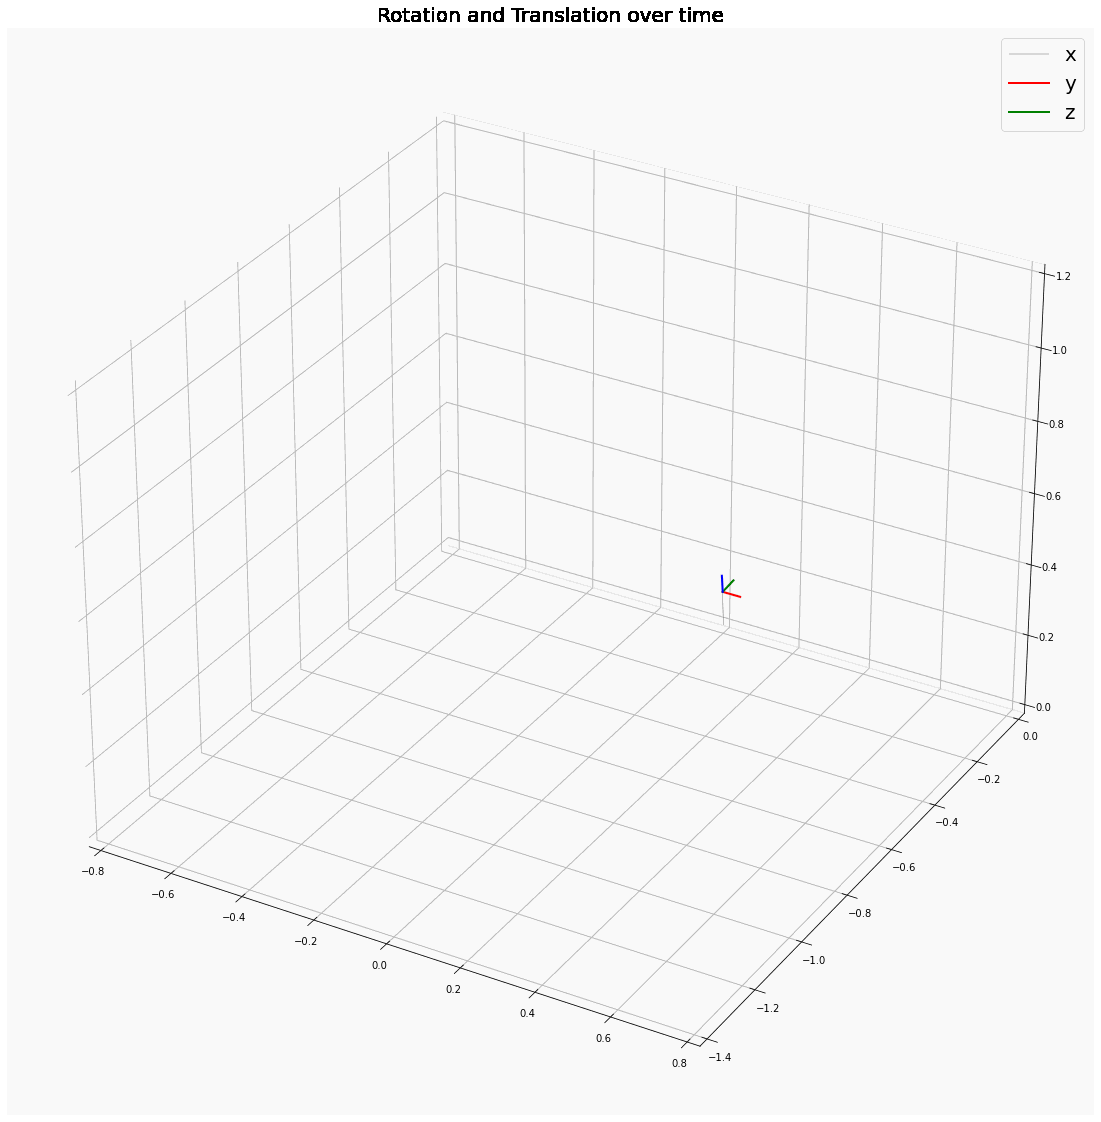

In [8]:
# load the images and create a gif
images = []
for k in range(step):
    filename = 'animation/rotation_translation_%03d.png' % k
    images.append(imageio.imread(filename))
imageio.mimsave('rotation_translation.gif', images, duration=3000/20)

with open('rotation_translation.gif','rb') as file:
    display(Image(file.read(), format='png', width=500, height=500))

### Tools
- [3D Rotation Converter](https://www.andre-gaschler.com/rotationconverter/)
- [Formats - MichaelGrupp/evo](https://github.com/MichaelGrupp/evo/wiki/Formats)